# SigOpt for TensorFlow Introduction

>*This notebook is created by Tobias Andreasen. For any comments, suggestions etc., please contact TobiasAndreasen1992@gmail.com. *

The **Black Box Optimization Tool** SigOpt (https://sigopt.com/) allows you to do easy **Hyperparameter tuning**, which in most cases helps improving performance of various models.

SigOpt is a black box optimization tool in the sense that it runs completly on The SigOpt backend **WITHOUT** ever seeing the actual data. What SigOpt requires is a set of hyperparameters and one or two matricies on which you want to maximize performance.

>*Please see https://sigopt.com/ for questions regarding SigOpt licensing *

>* The two classification examples (a simple first and a more complex second) in this notebook are based on examples from https://www.tensorflow.org/tutorials/image_recognition to build on the tensorflow tutorial exposure that tensorflow users would already have. The use of the examples is under the creative commons attribution 3.0 license which can be found at https://creativecommons.org/licenses/by/3.0/legalcode or in human readable format at https://creativecommons.org/licenses/by/3.0/*


In this notebook, I employ the above classificaiton examples as a tutorial vehicle to introduce some of the features that SigOpt provides for working in a Python enviroment. For simplicity  we will be using the MNIST-dataset. The MNIST-dataset comprises roughly 60,000 images of handwriten digits, which we want to classify. See the pictures later in the notebook. Interested users can have fun with substituting the notMNINST dataset at https://github.com/davidflanagan/notMNIST-to-MNIST for the MINST dataset.*

In [2]:
from __future__ import print_function
from IPython.display import display, clear_output

import requests
from ipywidgets import Image

import sigopt
import matplotlib.pyplot as plt
from math import ceil
import time

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def plot_images(images, title, imgsize):
    n = images.shape[0]
    n_cols = 10
    n_rows = ceil(n / n_cols)
    plt.figure(figsize=(1.8 * n_cols, 2 * n_rows))
    plt.suptitle(title)
    for i in range(n):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plot_image(ax, images[i,:], imgsize)
        
def plot_image(ax, image, imgsize):
    plt.imshow(image.reshape(imgsize), cmap='Greys_r')
    plt.xticks(())
    plt.yticks(())

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# SigOpt for TensorFlow Introduction

>*This notebook is created by Tobias Andreasen. For any comments, suggestions ect please contact TobiasAndreasen1992@gmail.com for any question regarding license please see https://sigopt.com/*


The **Black Box Optimization Tool** SigOpt (https://sigopt.com/) allows you to do easy **Hyperparameter tuning**, which in most cases helps improving performance of various models.

SigOpt is a black box optimization tool in the sense that it runs completly on The SigOpt backend **WITHOUT** ever seeing the actual data. What SigOpt requires is a set of hyperparameters and one or two matricies on which you want to maximize performance.

The following will introduce two hands-on examples created in TensorFlow (https://www.tensorflow.org/), where I introduce some of the features that SigOpt provides working in a Python enviroment. For simplicity we will be looking at two classification problems, and for that we will be using the MNIST-dataset. The MNIST-dataset comprises roughly 60.000 images of handwriten digits, which we want to classify. See the pictures below:

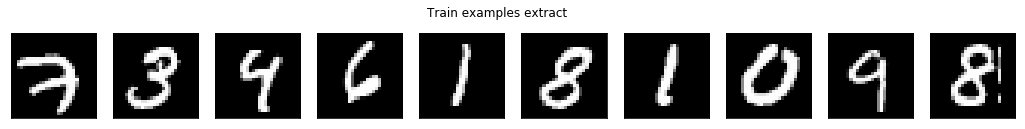

In [2]:
plot_images(mnist.train.images[:10,:], "Train examples extract", (28,28))
plt.show()

SigOpt differs from most open-source tools due to the fact that it uses a trade-off between Exploitation and Exploration.
Most open-source tools are only interested in optimizing the first found optimum through a series of iterations without even considering the potential of additional optimums.
SigOpt outperforms these tools by having the ability to jump between optimums, because it tries to maximize the information it recives after every given iteration.

For more information I can recommand the following podcast: https://soundcloud.com/twiml/twiml-talk-050-bayesian-optimization-hyperparameter-tuning-scott-clark


>SigOpt automates the tuning of your model’s ***hyper, feature, and architecture parameters.*** If you’re not optimizing them, ***you’re forsaking significant performance and revenue gains.***

>Modelers often overlook these optimizations because traditional approaches like manual, grid, and random search are time-consuming and produce subpar results.

>Let SigOpt modernize your workflow so you can focus on what you’re best at: designing your model and understanding your data. <cite> https://sigopt.com/ <cite>



# Example - Simple Neural Network

The first example is an MNIST Image classification problem using a 2-layer neural network architecture:

**input $\rightarrow$ fully connected $\rightarrow$ activation $\rightarrow$ fully connected $\rightarrow$ output**

For this example we introduce 5 hyperparameters, that we want to use in order to increase performance of the model.

For using SigOpt, the first step is to create a connection to the SigOpt backend, by either using the API Token or the Development Token: https://sigopt.com/user/profile

***The Development Token is for debugging and DOES NOT count as an experiment.***

In [10]:
Image(value=requests.get('https://www.tensorflow.org/images/softmax-regression-scalargraph.png'
                        ).content, width=300, height=150)

# If it does not complie, run:
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [3]:
conn = sigopt.Connection(client_token="") 

Secondly we need to choose an observation budget. The observation budget corresponds to the number of iterations that we want to provide to SigOpt. SigOpt suggests to use a budget in the range of 10-20 times the number of hyperparameters.

In [4]:
observation_budget_experiment_1 = 100

It is possible to create an experiment via the SigOpt API, but this can also be done using Python. When creating the experiment, the following pieces of information need to be specified:

* Name of the experiment
* Hyperparameters, including spans
* Metrics/objective
* Observation Budget

Choosing the hyperparameter spans is based on knowlegde of the person implementing the model, ***but throughout the experiment these can be changed using the SigOpt API.***

It is possible to choose three types of Hyperparameters:

1. Floating point values
2. Categorical values
3. Integer values

In [5]:
experiments = conn.experiments().create(
    name = "SigOpt_Workshop_Example_1",
        parameters = [
            
          # DOUBLE
          {'name': 'lr',         'type': 'double', 'bounds': {'min': 5e-9, 'max': 5e-1}}, # learning rate
            
          # Categorical
          {'name': 'activation', 'type': 'categorical', 'categorical_values': ['softmax', 'relu', 'softplus']}, # activation
          
          # Integer  
          {'name': 'nodes',      'type': 'int', 'bounds': {'min': 50, 'max': 200}}, # nodes in second hiddden layer
          {'name': 'iterations', 'type': 'int', 'bounds': {'min': 100, 'max': 1500}}, # number of training iterations
          {'name': 'batch_size', 'type': 'int', 'bounds': {'min': 1, 'max': 200}}, # batch size
          
        ], metrics=[ dict(name="accuracy") ],
      observation_budget = observation_budget_experiment_1)

After an experiment has been created, the experiment ID has to be retrived. It can also be accessed via the SigOpt API: https://sigopt.com/experiments

In [6]:
ID = experiments.id
print(ID)

28839


The final step is to create a loop that trains the model a number of times corresponding to the observation budget. Every iteration will then consist of four steps:

1. Get Hyperparameter suggestion from SigOpt
2. Generat model with the given hyperparameters
3. Train and evaluate the model
4. Return information to Sigopt

While this is running the results can be monitored on: https://sigopt.com/experiments 

***It is worth noticing that this is a toy example, and that the performance can be increased by increasing the number of training iterations.***

In [13]:
try:

    for _ in range(observation_budget):

        
        """Get Hyperparameter suggestion from SigOpt"""
        suggestion = conn.experiments(ID).suggestions().create()
        params = suggestion.assignments

        activation = params['activation']
        nodes = params['nodes']
        lr = params['lr']
        iterations = params['iterations']
        batch_size = params['batch_size']

        
        """Generat model with the given Hyperparameter"""
        tf.reset_default_graph()

        x = tf.placeholder(tf.float32, [None, 784])
        y_ = tf.placeholder(tf.float32, [None, 10])

        with tf.name_scope('scope'):
            W_1 = tf.Variable(tf.zeros([784, nodes]), name='W_1')
            b_1 = tf.Variable(tf.zeros([nodes]), name='b_1')

            W_2 = tf.Variable(tf.zeros([nodes, 10]), name='W_2')
            b_2 = tf.Variable(tf.zeros([10]), name='b_2')

        z = getattr(tf.nn, activation)(tf.matmul(x, W_1) + b_1)
        y = tf.nn.softmax(tf.matmul(z, W_2) + b_2)

        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
        train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)


        sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()
        
        
        """Train and evaluate the model"""
        for i in range(iterations):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        result = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        
        
        """Return information to Sigopt"""
        conn.experiments(ID).observations().create(
        suggestion=suggestion.id,
        value=float(result)) # if only one objective we return using value

        
except:
    KeyboardInterrupt

Now that we have shown that our basic setup works, and we are ready to dig a little bit deeper into what SigOpt has to offer.

# Example - Deep Convolutional Network

For the second example we are still looking at the MNIST dataset but this time we're choosing a deeper architecture. We do this for two reasons. First, we want to include more hyperparameters and secondly this type model also happen to be very multimodal; meaning that they have multiple optimums. The model architecture chosen is pictured below.

In [11]:
Image(value=requests.get('https://www.tensorflow.org/images/mnist_deep.png').content, width=300, height=600)

# If it does not complie, run:
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

# Helper functions

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def unpack_hp(params):
    return (params['f_1'], params['f_2'], params['k_1'], params['k_2'],
           params['a_1'], params['a_2'], params['o_s'], params['do'],
           params['lr'], params['opt'], params['b_s'], params['i'])

For the second experiment we are interested in investigating if the model we are looking at has multiple optimums with equavalent performance.

Together with the increase in the number of hyperparameters, we decide to also increase our observation budget.

In [9]:
observation_budget_experiment_2 = 200

For this experiment we are including 12 hyperparameters, where 2 are floating points, 3 are categorical and 7 are integers. Choosing a large number of categorical values can sometimes be problematic, since the SigOpt-model has to search through all the vertices of a hypercube of size $g^{k}$, where $g$ is the number of potential hyperparameter-values and $k$ is the number of categorical hyperparameters.

In [10]:
epsilon = 0.0000001 # The SigOpt parameter spans are inclusive, so due to the numerical instability of
                    # some hyperparameters, we include a small epsilon.

experiments = conn.experiments().create(
    name = "SigOpt_Workshop_Example_2",
        parameters = [
            
          # DOUBLE
          {'name': 'lr', 'type': 'double', 'bounds': {'min': 5e-9, 'max': 5e-1}}, # learning rate
          {'name': 'do', 'type': 'double', 'bounds': {'min': 0+epsilon, 'max': 1-epsilon}}, # dropout rate
            
          # Categorical
          {'name': 'a_1', 'type': 'categorical', 'categorical_values': ['softmax', 'relu', 'softplus']}, # activation 1
          {'name': 'a_2', 'type': 'categorical', 'categorical_values': ['softmax', 'relu', 'softplus']}, # activations 2
          {'name': 'opt', 'type': 'categorical', 'categorical_values': ['AdamOptimizer', 'AdadeltaOptimizer']}, # optimizer
            
          # Integer  
          {'name': 'f_1', 'type': 'int', 'bounds': {'min': 1, 'max':75}}, # numbers of filters in first layer
          {'name': 'f_2', 'type': 'int', 'bounds': {'min': 1, 'max': 75}}, # numbers of filters in second layer
          {'name': 'k_1', 'type': 'int', 'bounds': {'min': 2, 'max': 10}}, # kernel size in first layer
          {'name': 'k_2', 'type': 'int', 'bounds': {'min': 2, 'max': 10}}, # kernel size in second layer
          {'name': 'o_s', 'type': 'int', 'bounds': {'min': 500, 'max': 2500}}, # size of first fully connected layer 
          {'name': 'b_s', 'type': 'int', 'bounds': {'min': 1, 'max': 100}}, # batch size  
          {'name': 'i',   'type': 'int', 'bounds': {'min': 50, 'max': 1000}}, # number of training iterations  
            
        ], metrics=[ {'name': 'accuracy'}, {'name': 'train_time'} ],
      observation_budget = observation_budget_experiment_2)

Since we are assuming that the model we are working with has multiple optimums, we will try to find a good trade-off between the accuracy of the model and the time it takes to train the model.
To do so we will be maximizing over the accuracy but also the negative of the training time.

The remaining code follows the procedure from the previous example:

In [11]:
ID = experiments.id
print(ID)

28840


***Again, it is worth noticing that this is a toy example, and that the performance can be increased by increasing the number of training iterations.***

Increasing the number of training iterations to 20.000 gives an accuracy of 99.2% but take roughly half an hour to train on a normal CPU.

By optimizing over the accuracy as well as the negative training time, we want to see if we can hit that performance at a much lower training time.

In [8]:
try:

    for _ in range(observation_budget):
        

        """Get Hyperparameter suggestion from SigOpt"""
        suggestion = conn.experiments(ID).suggestions().create()
        params = suggestion.assignments

        # Hyperparameters
        num_filters_1, num_filters_2, size_kernel_1, size_kernel_2,\
        activation_1, activation_2, output_size, dropout, learning_rate,\
        optim_func, batch_size, iterations = unpack_hp(params)
        
        
        """Generat model with the given Hyperparameter"""
        tf.reset_default_graph()

        # input
        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])
        x_image = tf.reshape(x, [-1, 28, 28, 1])


        # Layer 1
        W_conv1 = weight_variable([size_kernel_1,
                                   size_kernel_1,
                                   1,
                                   num_filters_1])

        b_conv1 = bias_variable([num_filters_1])

        h_conv1 = getattr(tf.nn, activation_1)(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)


        # Layer 2
        W_conv2 = weight_variable([size_kernel_2,
                                   size_kernel_2,
                                   num_filters_1,
                                   num_filters_2])

        b_conv2 = bias_variable([num_filters_2])


        h_conv2 = getattr(tf.nn, activation_2)(conv2d(h_pool1, W_conv2) + b_conv2)

        h_pool2 = max_pool_2x2(h_conv2)


        # fully connected 1
        W_fc1 = weight_variable([int(h_pool2.shape[1])**2 * num_filters_2, output_size])
        b_fc1 = bias_variable([output_size])

        h_pool2_flat = tf.reshape(h_pool2, [-1, int(h_pool2.shape[1])**2 * num_filters_2])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


        # fully connected 2
        W_fc2 = weight_variable([output_size, 10])
        b_fc2 = bias_variable([10])


        # output layer
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))


        train_step = getattr(tf.train, optim_func)(learning_rate).minimize(cross_entropy)


        correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


        sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()

        time_start = time.time()
        
        
        """Train and evaluate the model"""
        for i in range(iterations):
            batch = mnist.train.next_batch(batch_size)
            train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: dropout})

        time_end = time.time()
        
        # Evaluate model
        acc = accuracy.eval(feed_dict={
            x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
        train_time = time_start-time_end # we want to maximize the negative time in order to reduce it

        
        """Return information to Sigopt"""
        result = [{'name': 'accuracy', 'value': float(acc)},
                  {'name': 'train_time', 'value': float(train_time)}]

        conn.experiments(ID).observations().create(
        suggestion=suggestion.id,
        values=result) # if two objectives we return using values

        
except:
    KeyboardInterrupt

For this example we have tried to update a model with competing objectives. For doing this type of optimization it important to become familiar with the term **Pareto Efficiency** (https://en.wikipedia.org/wiki/Pareto_efficiency). The following blogpost gives an additional intuition: https://blog.sigopt.com/posts/intro-to-multicriteria-optimization